***

# Final Project for the Course "Deep Learning for the Social Sciences"

**Authors:**

- Valentin Velev (Matriculation number: 1358229)
- ... ()
- ... ()
- ... ()

***

### Preparation

In [1]:
#import subprocess
#subprocess.run(['pip', 'install', 'langdetect'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Data Processing and Visualization
import pandas as pd
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from langdetect import detect, DetectorFactory
from wordcloud import WordCloud
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Machine Learning
import transformers
from transformers import GPT2Tokenizer, pipeline, AutoTokenizer
import torch

# Other
import random
import nltk
import os
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Valentin
[nltk_data]     Velev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Valentin
[nltk_data]     Velev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Set random seeds for reproducible and consistent results
random.seed(42)

np.random.seed(42)

torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

### 1 Data Collection

In [ ]:
if os.path.exists('/kaggle/input'):
    reviews = pd.read_csv('/kaggle/input/amazon-product-reviews/Reviews.csv')
else:
    with ZipFile('Reviews.csv.zip', 'r') as zip:
        with zip.open('Reviews.csv') as file:
            reviews = pd.read_csv(file)

In [ ]:
# Check the first 5 observations
print('----------------------------------------\nThe first 5 observations of the dataset:\n----------------------------------------')
display(reviews.head())

# Check the number of observations and features
print('--------------------------\nDimensions of the dataset:\n--------------------------\n')
print('Observations: ' + str(reviews.shape[0]))
print('Variables: ' + str(reviews.shape[1]))
print('Unique Products: ' + str(len(reviews['ProductId'].unique())))

#
print('\n--------------------------\nMissing data distribution:\n--------------------------\n')
print(reviews.isna().sum())

### 2 Data Cleaning

#### Removing duplicates, non-English posts, and irrelevant content

In [ ]:
# Setting a consistent seed
DetectorFactory.seed = 12345

# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown/not recognizable'

# Apply the function to detect language
reviews['Language'] = reviews['Text'].apply(detect_language)

# Count the frequency of each language
language_counts = Counter(reviews['Language'])

# df_lang = pd.DataFrame.from_dict(language_counts).reset_index()

display(language_counts)

# Remove non-English reviews
reviews_eng = reviews[reviews['Language'] == 'en']

print('Observations without non-English reviews: ' + str(reviews_eng.shape[0]))

# Remove duplicates
reviews_eng_nodup = reviews_eng.drop_duplicates(subset=['ProductId', 'Text'], keep='first').reset_index(drop=True)

print('Observations without non-English reviews and duplicates: ' + str(reviews_eng_nodup.shape[0]))

# Function to check if the review contains any irrelevant keywords
def contains_irrelevant_keywords(text):
    keywords = ['shipping', 'delivery']
    return any(keyword in text.lower() for keyword in keywords)

# Apply the function to filter out irrelevant reviews
irrelevant = reviews_eng_nodup[reviews_eng_nodup['Text'].apply(contains_irrelevant_keywords)]

reviews_clean = reviews_eng_nodup.drop(irrelevant.index)

print('Observations without non-English reviews, duplicates, and irrelevant content: ' + str(reviews_clean.shape[0]))

#### Re-coding and subsetting

In [ ]:
# Convert time to date
reviews_clean['Date'] = pd.to_datetime(reviews_clean['Time'], unit='s')

# Remove irrelevant variables
reviews_clean.drop(['Id', 'ProfileName', 'UserId', 'Time', 'Language'], axis=1, inplace=True)

#
display(reviews_clean)

# Save as csv
reviews_clean.to_csv('data_preprocessed.csv', index=False)

#### Tokenization

In [ ]:
# Get a rough understanding of the tokens
revs = reviews_clean['Text'].copy()

doc_lengths = []

for rev in revs:
    tokens = nltk.word_tokenize(rev)
    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

#
sns.histplot(doc_lengths, kde=True)
plt.show()

#
print('Number of reviews with more than 1024 tokens:', str(np.sum(doc_lengths > 1024)))
print('Number of reviews with more than 512 tokens:', str(np.sum(doc_lengths > 512)))
print('Average number of tokens:', str(np.average(doc_lengths)))

In [3]:
reviews_clean = pd.read_csv('data_preprocessed.csv')

In [4]:
# Split on whitespaces, remove puncutation, remove stopwords
def clean_text(df, text_column):
    stop_words = set(stopwords.words('english'))
    punctuation_table = str.maketrans('', '', string.punctuation)
    
    def process_text(text):
        # Split text by whitespace
        words = word_tokenize(text)
        # Remove punctuation and stopwords
        cleaned_words = [word.translate(punctuation_table).lower() for word in words if word.isalnum() and word.lower() not in stop_words]
        return cleaned_words
    
    df[text_column + 'SplitAndCleaned'] = df[text_column].apply(process_text)
    return df

# Clean the text
reviews_clean_tokens = clean_text(reviews_clean, 'Text')

# Determine the review length
reviews_clean_tokens['TextLength'] = reviews_clean_tokens['TextSplitAndCleaned'].apply(len)

# Check the DataFrame
display(reviews_clean_tokens)

# ...
print('Number of reviews with more than 1024 tokens:', str(np.sum(reviews_clean_tokens['TextLength'] > 1024)))
print('Number of reviews with more than 512 tokens:', str(np.sum(reviews_clean_tokens['TextLength'] > 512)))
print('Number of reviews with more than 150 tokens:', str(np.sum(reviews_clean_tokens['TextLength'] > 150)))
print('Average number of tokens:', str(np.average(reviews_clean_tokens['TextLength'])))

,ProductId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,Date,TextSplitAndCleaned,TextLength
0,B001E4KFG0,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,"[bought, several, vitality, canned, dog, food,...",23
1,B00813GRG4,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,"[product, arrived, labeled, jumbo, salted, pea...",18
2,B000LQOCH0,1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,"[confection, around, centuries, light, pillowy...",39
3,B000UA0QIQ,3,3,2,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13,"[looking, secret, ingredient, robitussin, beli...",18
4,B006K2ZZ7K,0,0,4,Nice Taffy,I got a wild hair for taffy and ordered this f...,2012-07-12,"[got, wild, hair, taffy, ordered, five, pound,...",36
...,...,...,...,...,...,...,...,...,...
538158,B001EO7N10,0,0,5,Will not do without,Great for sesame chicken..this is a good if no...,2011-03-09,"[great, sesame, chicken, good, better, restura...",12
538159,B003S1WTCU,0,0,2,disappointed,I'm disappointed with the flavor. The chocolat...,2012-03-09,"[disappointed, flavor, chocolate, notes, espec...",22
538160,B004I613EE,2,2,5,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",2012-02-21,"[stars, small, give, one, training, session, t...",37
538161,B004I613EE,1,1,5,Favorite Training and reward treat,These are the BEST treats for training and rew...,2012-03-13,"[best, treats, training, rewarding, dog, good,...",18


Number of reviews with more than 1024 tokens: 11
Number of reviews with more than 512 tokens: 186
Number of reviews with more than 150 tokens: 11475
Average number of tokens: 39.28735345982537


#### Preliminary data analysis and visualization

##### Review Length

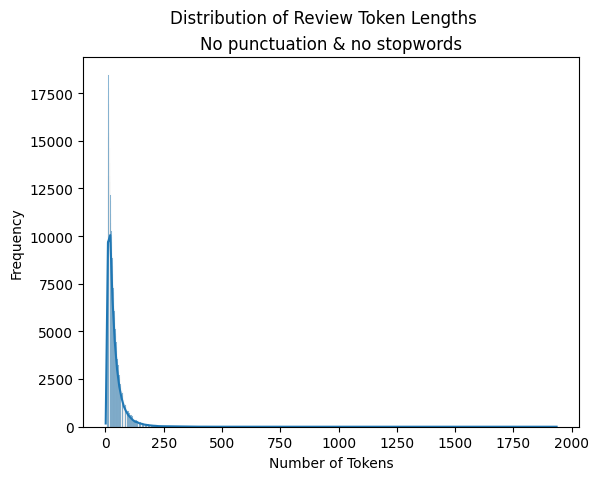

In [5]:
# Review length
sns.histplot(reviews_clean_tokens['TextLength'], kde=True)
plt.suptitle('Distribution of Review Token Lengths')
plt.title('No punctuation & no stopwords')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

##### Sentiment distribution

SiEBERT

In [15]:
# Truncate long texts
reviews_clean_tokens_subset = reviews_clean_tokens.copy()
reviews_clean_tokens_subset = reviews_clean_tokens_subset[reviews_clean_tokens_subset['TextLength'] <= 100]

# Randomly sample 100 000 texts
reviews_clean_tokens_subset = reviews_clean_tokens_subset.sample(n=20000, random_state=1)

# Load a pre-trained sentiment analysis model
classifier = pipeline('sentiment-analysis', model='siebert/sentiment-roberta-large-english')

def analyze_sentiment(df, text_column):
    # Initialize empty lists to store the results
    sentiments = []
    scores = []

    for text in df[text_column]:
        result = classifier(text)[0]
        sentiments.append(result['label'])
        scores.append(result['score'])

    # Add results to the DataFrame
    df['Sentiment_SiEBERT'] = sentiments

    return df

#
reviews_clean_tokens_subset_sentiment = analyze_sentiment(reviews_clean_tokens_subset, 'Text')

,ProductId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,Date,TextSplitAndCleaned,TextLength,Sentiment_SiEBERT
189548,B001M23WBY,0,1,1,New great grains version os tasteless product,The new Great Grains version of Post Cereal Ba...,2012-03-23,"[new, great, grains, version, post, cereal, ba...",29,NEGATIVE
10739,B0041QD39O,0,0,3,I've had better,camerons organic velvet moon is way better. Co...,2012-10-10,"[camerons, organic, velvet, moon, way, better,...",11,NEGATIVE
227802,B000G7I7DO,0,0,3,Just okay,The container itself is smaller than I thought...,2008-06-02,"[container, smaller, thought, pieces, leave, m...",24,NEGATIVE
245396,B001PICX42,0,0,4,Delicious!,Delicious and healthy snack! I would have to ...,2011-07-22,"[delicious, healthy, snack, would, say, better...",22,POSITIVE
263789,B00311T538,0,0,5,Much richer than typical clover honey,I drink a lot of tea with honey so I was anxio...,2012-10-03,"[drink, lot, tea, honey, anxious, sample, prod...",15,POSITIVE
...,...,...,...,...,...,...,...,...,...,...
308056,B0033GMSTY,1,1,5,Fantastic cup of coffee,I am giving this coffee a 5 star excellent rat...,2012-02-07,"[giving, coffee, 5, star, excellent, rating, a...",28,POSITIVE
43468,B0041NYV8E,1,1,5,Great punch of ginger in a soothing hot beverage!,This ginger/lemon beverage was such a nice sur...,2012-02-23,"[beverage, nice, surprise, usually, get, somet...",61,POSITIVE
136415,B000I1RGQC,0,0,5,Wonderful flavor,I have been trying to eat better and am switch...,2011-08-07,"[trying, eat, better, switching, foods, used, ...",61,POSITIVE
500099,B000MDCDJ6,2,2,5,Great stuff!,"I love this stuff for a quick lunch, especiall...",2010-09-21,"[love, stuff, quick, lunch, especially, handy,...",18,POSITIVE


VADER

In [18]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Sentiment distribution
## Define function
def analyze_sentiment_vader(texts):
    sentiments = []
    scores = []

    for text in texts:
        sentiment_dict = sia.polarity_scores(text)
        # Get the compound score which is a normalized, weighted composite score
        compound = sentiment_dict['compound']
        # Determine sentiment label based on compound score
        if compound >= 0.05:
            sentiment = 'POSITIVE'
        elif compound <= -0.05:
            sentiment = 'NEGATIVE'
        else:
            sentiment = 'NEUTRAL'
        sentiments.append(sentiment)
        scores.append(compound)
    
    return sentiments

## Apply sentiment analysis to the DataFrame
texts = reviews_clean_tokens_subset_sentiment['Text'].tolist()
sentiments = analyze_sentiment_vader(texts)

## Add results to the DataFrame
reviews_clean_tokens_subset_sentiment['Sentiment_VADER'] = sentiments

[nltk_data] Downloading package vader_lexicon to C:\Users\Valentin
[nltk_data]     Velev\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [21]:
reviews_clean_tokens_subset_sentiment.to_csv('data_preprocessed_sentiment.csv', index=False)

In [9]:
# Load the data with the sentiments
reviews_clean_tokens_subset_sentiment = pd.read_csv('data_preprocessed_sentiment.csv')

# Convert tokens column into lists instead of strings
import ast

def convert_string_to_list(string):
    try:
        # Evaluating the string as a list
        return ast.literal_eval(string)
    except ValueError:
        # Return an empty list or None if conversion fails
        return []

reviews_clean_tokens_subset_sentiment['TextSplitAndCleaned'] = reviews_clean_tokens_subset_sentiment['TextSplitAndCleaned'].apply(convert_string_to_list)

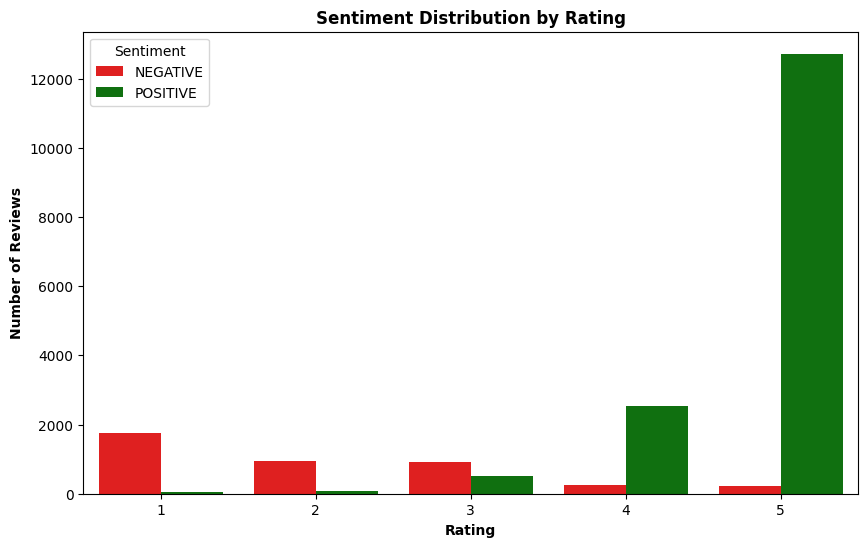

In [10]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Group by Review_Score and Sentiment
sentiment_distribution = reviews_clean_tokens_subset_sentiment.groupby(['Score', 'Sentiment_SiEBERT']).size().reset_index(name='Count')

# Plot bar graph using seaborn
sns.barplot(x='Score', y='Count', hue='Sentiment_SiEBERT', data=sentiment_distribution, palette=['red', 'green'])

# Set plot title and labels
plt.title('Sentiment Distribution by Rating', weight='bold')
plt.xlabel('Rating', weight='bold')
plt.ylabel('Number of Reviews', weight='bold')
plt.legend(title='Sentiment')

# Save the plot
plt.savefig('sentiment_dist_by_rating.pdf', dpi=1500)

# Show the plot
plt.show()

##### Wordclouds

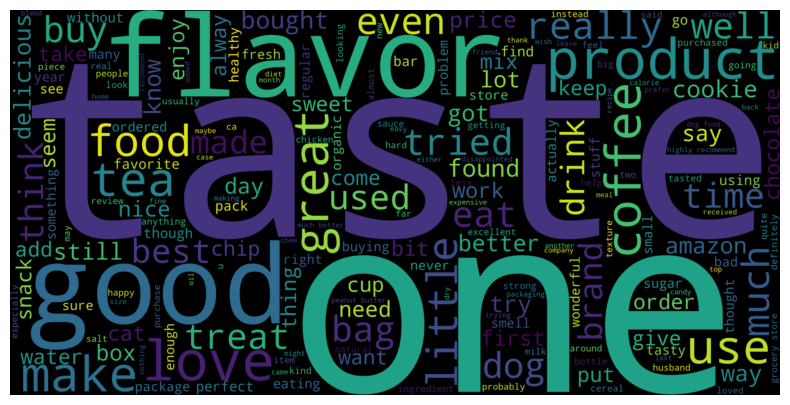

In [18]:
reviews_clean_tokens_subset_sentiment_wordclouds = reviews_clean_tokens_subset_sentiment.copy()
reviews_clean_tokens_subset_sentiment_wordclouds['TextSplitAndCleaned'] = reviews_clean_tokens_subset_sentiment_wordclouds['TextSplitAndCleaned'].apply(lambda word_list: [word for word in word_list if word != 'br'])

# Combine the words into a single string
text = ' '.join([' '.join(review) for review in reviews_clean_tokens_subset_sentiment_wordclouds['TextSplitAndCleaned']])

# Wordcloud of common words
wordcloud = WordCloud(width=4000, height=2000, background_color ='black').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('wordcloud.pdf', format='pdf', dpi=1500)
plt.show()

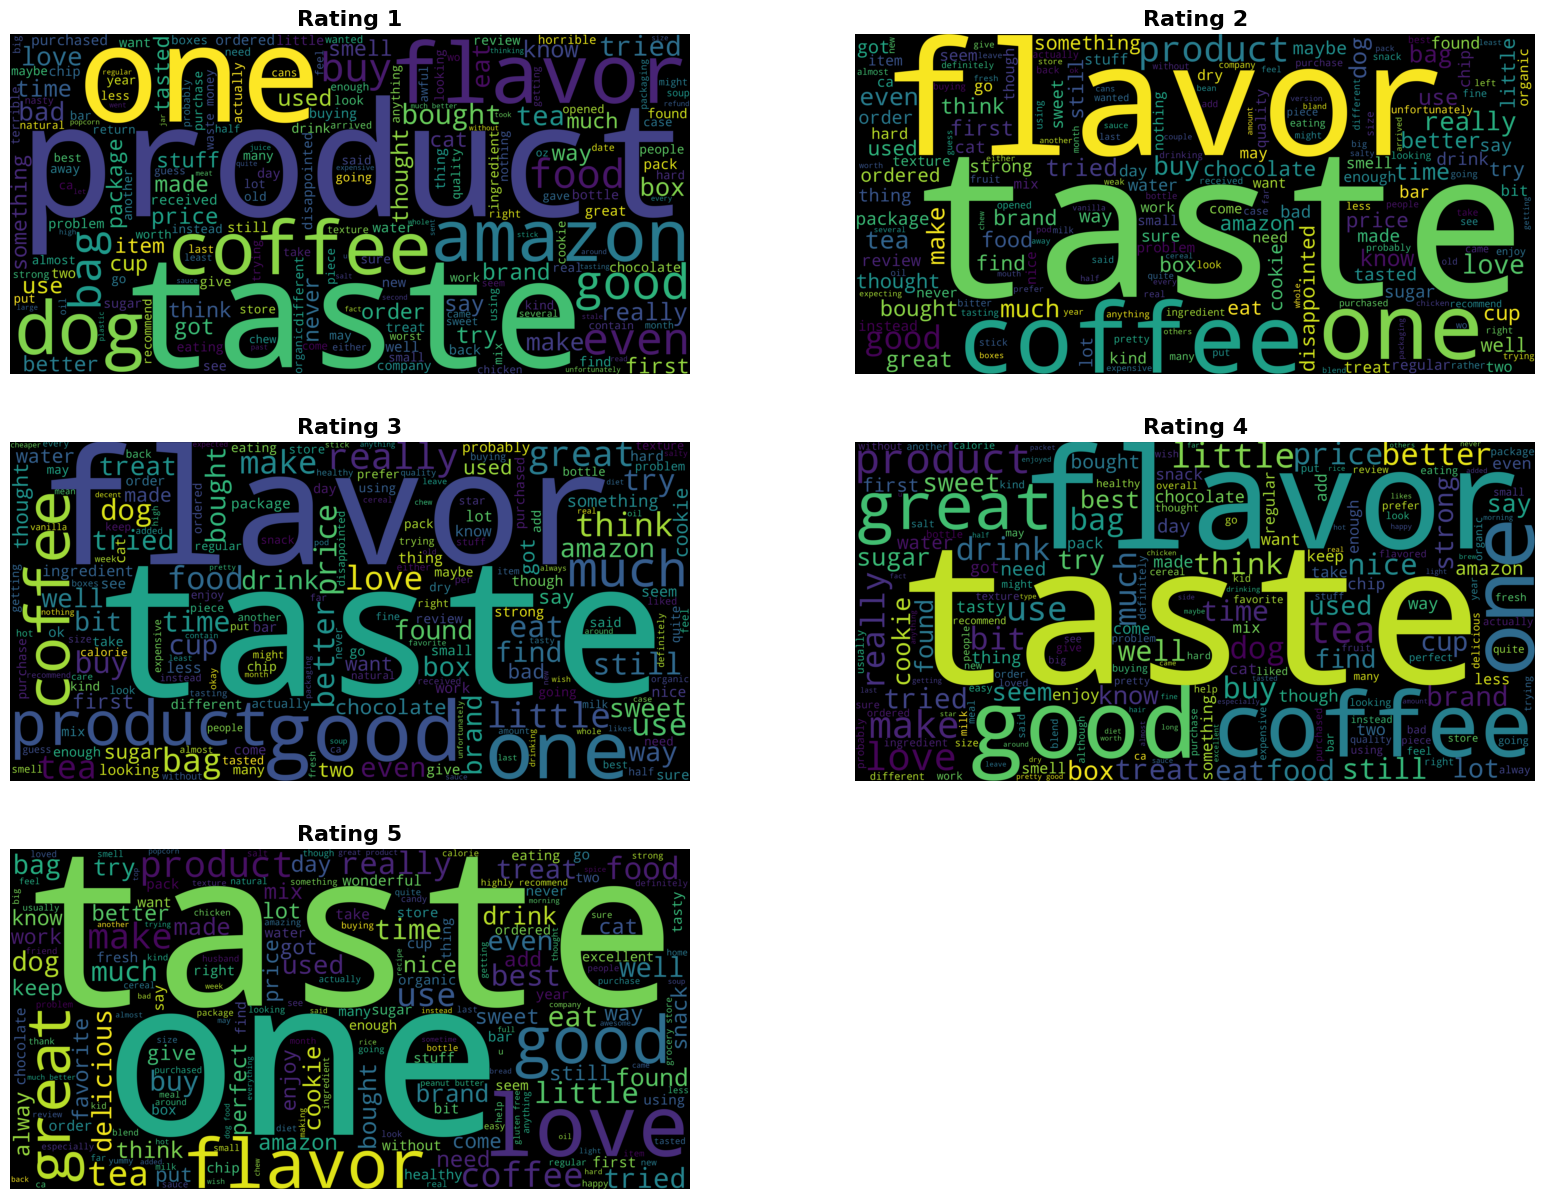

In [16]:
# Define a function to generate word cloud for a given rating
def generate_wordcloud_for_rating(df, rating):
    # Filter the DataFrame for the given rating
    filtered_df = df[df['Score'] == rating]
    # Combine the text from the 'Cleaned_Text' column into a single string
    text = ' '.join([' '.join(review) for review in filtered_df['TextSplitAndCleaned']])
    # Generate the word cloud
    wordcloud = WordCloud(width=4000, height=2000, background_color='black').generate(text)
    return wordcloud

# Create a figure with subplots for each rating
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

# Generate and plot word clouds for each rating
for rating in range(1, 6):
    wordcloud = generate_wordcloud_for_rating(reviews_clean_tokens_subset_sentiment_wordclouds, rating)
    ax = axes[(rating-1) // 2, (rating-1) % 2]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Rating {rating}', fontsize=16, weight='bold')
    ax.axis('off')

# Adjust layout and remove the empty subplot
plt.delaxes(axes[2][1])  # remove the empty subplot if there is any
plt.savefig('wordclouds_by_rating.pdf', format='pdf', dpi=1500)
plt.show()

##### Rating Distribution

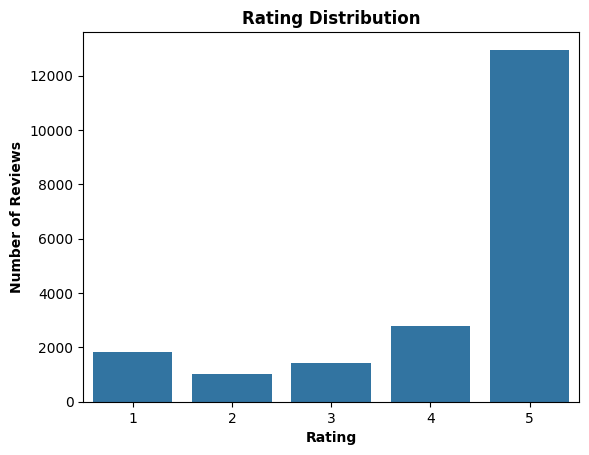

In [17]:
# Group by Review_Score and Sentiment
sentiment_distribution = reviews_clean_tokens_subset_sentiment.groupby(['Score']).size().reset_index(name='Count')

# Plot bar graph
sns.barplot(x='Score', y='Count', data=sentiment_distribution)
plt.title('Rating Distribution', weight='bold')
plt.xlabel('Rating', weight='bold')
plt.ylabel('Number of Reviews', weight='bold')
plt.savefig('rating_dist.pdf', format='pdf', dpi=1500)
plt.show()